# 6章 機械学習  
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．  

 1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
 2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
 3. 抽出された事例をランダムに並び替える．
 4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．  

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset

--2022-02-17 11:39:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  13.2MB/s    in 2.1s    

2022-02-17 11:39:41 (13.2 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:

'''
newsCorpora.csvはpublisher情報を含むデータセット.
FILENAME #1: newsCorpora.csv (102.297.000 bytes)
DESCRIPTION: News pages
FORMAT: ID \t TITLE \t URL \t PUBLISHER \t CATEGORY \t STORY \t HOSTNAME \t TIMESTAMP

where:
ID		Numeric ID
TITLE		News title 記事見出し
URL		Url
PUBLISHER	Publisher name
CATEGORY	News category (b = business, t = science and technology, e = entertainment, m = health)　カテゴリ
STORY		Alphanumeric ID of the cluster that includes news about the same story
HOSTNAME	Url hostname
TIMESTAMP 	Approximate time the news was published, as the number of milliseconds since the epoch 00:00:00 GMT, January 1, 1970
'''
filename = 'newsCorpora.csv'
targetPublishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
extractedArticles = list()

with open(filename, mode='r') as f:
  for line in f:
    formatItems = line.replace('\n','').split('\t')
    if formatItems[3] in targetPublishers:
      extractedArticles.append(formatItems)

In [3]:
extractedArticles[:2]

[['13',
  'Europe reaches crunch point on banking union',
  'http://in.reuters.com/article/2014/03/10/eu-banks-resoluton-idINL6N0M71NJ20140310',
  'Reuters',
  'b',
  'dPhGU51DcrolUIMxbRm0InaHGA2XM',
  'in.reuters.com',
  '1394470501755'],
 ['14',
  "ECB FOCUS-Stronger euro drowns out ECB's message to keep rates low for  ...",
  'http://in.reuters.com/article/2014/03/10/ecb-policy-idINL6N0M71K320140310',
  'Reuters',
  'b',
  'dPhGU51DcrolUIMxbRm0InaHGA2XM',
  'in.reuters.com',
  '1394470501948']]

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

trainArticles, restArticles = train_test_split(extractedArticles, train_size=0.8, shuffle=True)#shuffle is true on default
validArticles, testArticles = train_test_split(restArticles, train_size=0.5)

print(len(trainArticles)/len(extractedArticles), len(validArticles)/len(extractedArticles), len(testArticles)/len(extractedArticles))

for file in [['train.txt',trainArticles], ['valid.txt', validArticles],['test.txt',testArticles]]:
  with open(file[0],'w') as f:
    for article in file[1]:
      f.write("{}\t{}\n".format(article[4], article[1]))#カテゴリ\t記事見出し

0.7999401018268942 0.10002994908655286 0.10002994908655286


In [5]:
#News category (b = business, t = science and technology, e = entertainment, m = health)
!cat test.txt | cut -f 1 | sort | uniq -c
!echo -----
!cat train.txt | cut -f 1 | sort | uniq -c

    547 b
    520 e
     91 m
    178 t
-----
   4507 b
   4250 e
    723 m
   1204 t


In [14]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# データの保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


## 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう

In [16]:
import pandas as pd
import string
import re

def preprocessing(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(table)  # 記号をスペースに置換
  text = text.lower()  # 小文字化
  text = re.sub('[0-9]+', '0', text)  # 数字列を0に置換

  return text

In [18]:
trainArticles = pd.Series(trainArticles)
validArticles = pd.Series(validArticles)
testArticles = pd.Series(testArticles)

# データの再結合
df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True)  # indexを振りなおす

# 前処理の実施
df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))

print(df.head())

                                               TITLE CATEGORY
0  refile update 0 european car sales up for sixt...        b
1  amazon plans to fight ftc over mobile app purc...        t
2  kids still get codeine in emergency rooms desp...        m
3  what on earth happened between solange and jay...        e
4  nato missile defense is flight tested over hawaii        b


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer #term frequency–inverse document frequency

# データの分割
train_valid = df[:len(train) + len(valid)]
test = df[len(train) + len(valid):]

# TfidfVectorizer: https://gotutiyan.hatenablog.com/entry/2020/09/10/181919
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))  # ngram_rangeでTF-IDFを計算する単語の長さを指定 #min_dfはカウントする最低の頻出数


# ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])  # testの情報は使わない #fit_transform
X_test = vec_tfidf.transform(test['TITLE'])#transform
#fit, transform, fit_transformについて：https://mathwords.net/fittransform

# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names())

# データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]

# データの保存
X_train.to_csv('./X_train.txt', sep='\t', index=False)
X_valid.to_csv('./X_valid.txt', sep='\t', index=False)
X_test.to_csv('./X_test.txt', sep='\t', index=False)

print(X_train.head())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


    0m  0million  0nd   0s  0st  ...  yuan  zac  zac efron  zendaya  zone
0  0.0       0.0  0.0  0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
1  0.0       0.0  0.0  0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
2  0.0       0.0  0.0  0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
3  0.0       0.0  0.0  0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
4  0.0       0.0  0.0  0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0

[5 rows x 2815 columns]


## 52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [21]:
#ロジスティック回帰：https://gmo-research.jp/research-column/logistic-regression-analysis
from sklearn.linear_model import LogisticRegression

# モデルの学習
lg = LogisticRegression(random_state=123, max_iter=10000)
lg.fit(X_train, train['CATEGORY'])


LogisticRegression(max_iter=10000, random_state=123)

## 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [22]:
import numpy as np

def score_lg(lg, X):
  return [np.max(lg.predict_proba(X), axis=1), lg.predict(X)] #why axis=1?
#predict, predict_proba: https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

In [23]:
train_pred = score_lg(lg, X_train)
test_pred = score_lg(lg, X_test)

print(train_pred)


[array([0.84027948, 0.67904336, 0.55638881, ..., 0.86051   , 0.61359296,
       0.90828249]), array(['b', 't', 'm', ..., 'b', 'm', 'e'], dtype=object)]


## 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [25]:
#accuracy_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])
print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')


正解率（学習データ）：0.927
正解率（評価データ）：0.885


## 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

[[4344   93    8   56]
 [  52 4173    2    8]
 [  96  125  494   13]
 [ 192  133    7  888]]


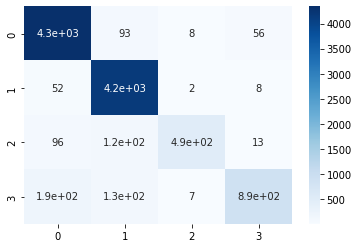

[[528  20   2  13]
 [ 12 516   1   1]
 [ 11  26  52   2]
 [ 38  26   1  87]]


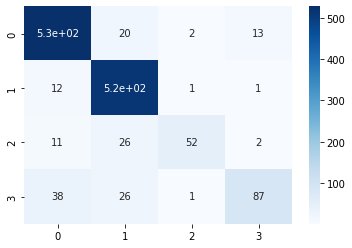

In [28]:
#混合行列：https://qiita.com/TsutomuNakamura/items/a1a6a02cb9bb0dcbb37f
#対角成分が正しい予測をした数。
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 学習データ
train_cm = confusion_matrix(train['CATEGORY'], train_pred[1])
print(train_cm)
sns.heatmap(train_cm, annot=True, cmap='Blues')
plt.show()

# 評価データ
test_cm = confusion_matrix(test['CATEGORY'], test_pred[1])
print(test_cm)
sns.heatmap(test_cm, annot=True, cmap='Blues')
plt.show()

#なんで5つのカテゴリへの分類で4カテゴリ分の行列になってるの？

## 56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

### マイクロ平均とは
**クラスごと**にF1値を計算し、平均したもの
正解率の場合：𝑛𝑖回のテストのうち，𝑥𝑖回が正解の場合，マイクロ平均は次式：
$\frac{\sum_{i=1}^{N} x_i}{\sum_{i=1}^{N} n_i}$

### マクロ平均とは
**全クラス**のF1値を計算したもの
正解率の場合：𝑛𝑖回のテストのうち，𝑥𝑖回が正解の場合，マクロ平均は次式：
$\frac{1}{N}\sum_{i=1}^{N}\frac{x_i}{n_i}$

In [29]:
# accuracy, precision, recall, f1-score: https://aiacademy.jp/texts/show/?id=34
#f-score in general: https://ja.wikipedia.org/wiki/F%E5%80%A4_(%E8%A9%95%E4%BE%A1%E6%8C%87%E6%A8%99)
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_scores(y_true, y_pred):
  # 適合率
  precision = precision_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])  # Noneを指定するとクラスごとの精度をndarrayで返す
  precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  # 末尾にマイクロ平均を追加
  precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  # 末尾にマクロ平均を追加

  # 再現率
  recall = recall_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
  recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
  recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # F1スコア
  f1 = f1_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
  f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
  f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # 結果を結合してデータフレーム化
  scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

  return scores


In [30]:
print(calculate_scores(test['CATEGORY'], test_pred[1]))


             適合率       再現率     F1スコア
b       0.896435  0.937833  0.916667
e       0.877551  0.973585  0.923077
t       0.844660  0.572368  0.682353
m       0.928571  0.571429  0.707483
マイクロ平均  0.885479  0.885479  0.885479
マクロ平均   0.886804  0.763804  0.807395


## 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [32]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):#特徴量、その重み
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T# method T transposes dataframe
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')


【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,bank,fed,china,ecb,stocks,euro,obamacare,oil,yellen,dollar
重要度下位,video,ebola,the,her,and,she,apple,google,star,microsoft




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,her,movie,star,film,paul,he,wedding,she
重要度下位,us,update,google,study,china,gm,ceo,facebook,apple,says




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,study,cancer,drug,mers,fda,cases,cdc,could,cigarettes
重要度下位,facebook,gm,ceo,apple,bank,deal,google,sales,climate,twitter




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,microsoft,climate,gm,nasa,tesla,comcast,heartbleed
重要度下位,stocks,fed,her,percent,drug,american,cancer,ukraine,still,shares


##58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [ ]:
#tqdm：ループ毎にプログレスバーが進む。
#np.logspace(-5, 4, 10, base=10)): start -5, stop 4, number of samples 10, in base10

#in logisticregression, C: (float, default=1.0)　Inverse of regularization strength; 
#must be a positive float. Like in support vector machines, smaller values specify stronger regularization.


In [33]:
from tqdm import tqdm

result = []
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
  # モデルの学習
  lg = LogisticRegression(random_state=123, max_iter=10000, C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  train_pred = score_lg(lg, X_train)
  valid_pred = score_lg(lg, X_valid)
  test_pred = score_lg(lg, X_test)

  # 正解率の算出
  train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])
  test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])

  # 結果の格納
  result.append([C, train_accuracy, valid_accuracy, test_accuracy])


100%|██████████| 10/10 [14:56<00:00, 89.68s/it] 


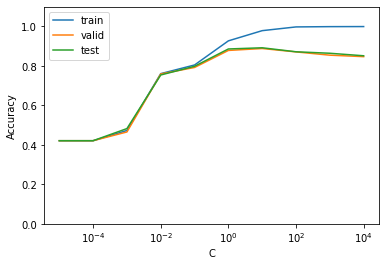

In [36]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()


##59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [37]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 210 kB 63.0 MB/s 
     |████████████████████████████████| 80 kB 9.0 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 113 kB 49.8 MB/s 
     |████████████████████████████████| 149 kB 63.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=fc517b1743df87f4ec1071cbd9c30abdab642de202074f9bf6fc17e8295ace04
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [38]:
#idea of optuna https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/001_first.html#sphx-glr-tutorial-10-key-features-001-first-py
import optuna

# 最適化対象を関数で指定
def objective_lg(trial):
  # チューニング対象パラメータのセット
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
  C = trial.suggest_loguniform('C', 1e-4, 1e4)

  # モデルの学習
  lg = LogisticRegression(random_state=123, 
                          max_iter=10000, 
                          penalty='elasticnet', 
                          solver='saga', 
                          l1_ratio=l1_ratio, 
                          C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  valid_pred = score_lg(lg, X_valid)

  # 正解率の算出
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])    

  return valid_accuracy 


In [ ]:
# 最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective_lg, timeout=3600)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))


[I 2022-02-17 14:44:39,496] A new study created in memory with name: no-name-bba85f49-0480-4ba2-b173-407f36045460
